In [7]:
from math import sqrt
from numpy import array, unravel_index, zeros, arange, meshgrid, outer, dot
from numpy import subtract, power, exp, pi
from numpy import nditer, random
from collections import defaultdict
from warnings import warn

In [5]:
def fast_norm(x):
    return sqrt(dot(x, x.T))

In [513]:
class Minisom2D(object):
    def __init__(self, x, y, input_len, sigma = 1.0, learning_rate = 0.5, decay_function = None, random_seed  = None):
        if sigma >= x/2 or sigma >= y/2:
            warn('WARNING: sigma to high for the dimension')
        self.random_generator = random.RandomState(random_seed) if random_seed else random.RandomState(0)
        self._decay_function = decay_function if decay_function else lambda x, t, max_iter: x/(1+t/max_iter)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian
        self.matriz = zeros((x,y))
        
    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()
            
    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def winner_ex(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self.matriz = zeros((self.weights.shape[0],self.weights.shape[1]))
        self._activate(x)
        next_it = True
        while next_it:
            index = unravel_index(self.activation_map.argmin(), self.activation_map.shape) 
            if self.matriz[index] < 10:
                self.matriz[index] += 1
                break
            else:
                self.activation_map[index] = infty
        return index

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            #self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            #self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()
        
    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(1, num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            rand_i = iteration%1000
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)
    
    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
                        #um[it.has_multi_index] += self.weights[ii, jj, :] - self.weights[it.multi_index]
            it.iternext()
        um = um/um.max()
        return um

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        Map = zeros((self.weights.shape[0], self.weights.shape[1]))
        winmap = defaultdict(list)
        for x in data:
            index = self.winner_ex(x)
            winmap[index].append(x)
        it = nditer(Map, flags=['multi_index'])
        while not it.finished:
            #div = len(winmap[it.multi_index])
            #if div == 0:
            #    Map[it.multi_index] = 4
            #else:
            value = sum(winmap[it.multi_index])/10
            if value <= 0.5:
                Map[it.multi_index] = 0
            else:
                if 0.5 < value <= 1.5:
                    Map[it.multi_index] = 1
                else:
                    if 1.5 < value <= 2.5:
                        Map[it.multi_index] = 2
                    else:
                        if 2.5 < value:
                            Map[it.multi_index] = 3
                        else:
                            Map[it.multi_index] = 4
            it.iternext()
        return Map #winmap

In [89]:
dic = defaultdict(list)
dic[0].append(1)
dic[0].append(2)
len(dic[0])

2

455


In [47]:
from numpy.random import randn

In [50]:
randn(1, 10)*0.5

array([[ 0.39478526, -0.11825894,  0.12667449,  0.71193861, -0.25511824,
        -0.84199027,  0.43711654,  0.46534667, -0.55801104, -0.45179897]])

In [69]:
import matplotlib.pyplot as plt

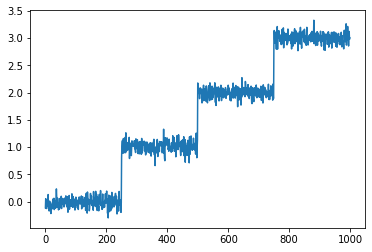

In [508]:
sigma_s = .1
n0 = randn(1, 250)*sigma_s
n1 = 1 + randn(1, 250)*sigma_s
n2 = 2 + randn(1, 250)*sigma_s
n3 = 3 + randn(1, 250)*sigma_s
plt.plot(arange(0, 1000), concatenate((n0, n1, n2, n3), axis = None))
plt.show()

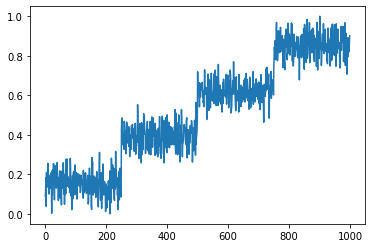

In [137]:
plt.plot(arange(0, 1000), Data)
plt.show()

In [218]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
from numpy import reshape
data = data.reshape(-1, 1)
Data = sc.fit_transform(data)

In [74]:
from numpy import concatenate

In [509]:
data = concatenate((n0, n1, n2, n3), axis = None)

In [515]:
SOM = Minisom2D(10, 10, 1, sigma=0.4, learning_rate=.75)
SOM.random_weights_init(data)

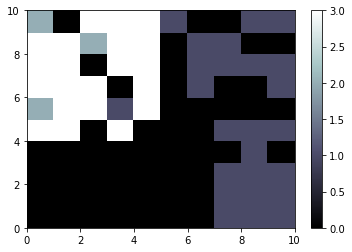

In [516]:
SOM.train_random(data = data, num_iteration = 12000)
mappings = SOM.win_map(data)
bone()
#pcolor(SOM.distance_map().T)
pcolor(mappings)
colorbar()
show()

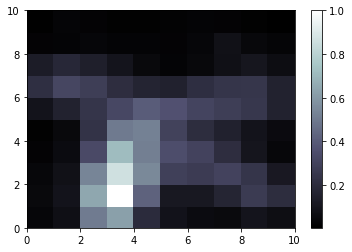

In [518]:
mappings = SOM.distance_map()
bone()
#pcolor(SOM.distance_map().T)
pcolor(mappings.T)
colorbar()
show()

In [257]:
mappings[(2,1)]

4.0

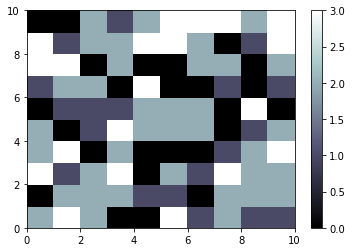

In [312]:
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show


In [103]:
from numpy import infty

In [159]:
dot([-0.1],[-0.1])

0.010000000000000002